In [1]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [2]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
import numpy as np

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [3]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        # Define the Actor architecture
        # TODO
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_size, action_dim),
            nn.Tanh()
        )
        self.std = nn.Linear(hidden_size, action_dim)


    def forward(self, state):
        #TODO
        x = self.layers(state)
        mu = self.mu(x)
        std = F.softplus(self.std(x))

        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        # Define the Critic architecture
        #TODO
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        # Predict the value of state
        value = self.value(state)
        return value


## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [ ]:
class PPO(nn.Module):
    def __init__(self, env, config, actor_path=None, critic_path=None):
        super(PPO, self).__init__()
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size

        self.lr = config.LEARNING_RATE
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)
        if actor_path is not None:
            # print("test")
            self.actor.load_state_dict(torch.load(actor_path, weights_only = True))
        if critic_path is not None:
            self.critic.load_state_dict(torch.load(critic_path, weights_only = True))

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory()

    def select_action(self, state):
        # Save state, action, log probability and state value of current step in the memory buffer.
        # predict the actions by sampling from a normal distribution
        # based on the mean and std calculated by actor
        #TODO
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        mu, std = self.actor(state)
        dist = MultivariateNormal(mu, torch.diag_embed(std**2))
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        value = self.critic(state)

        self.push_memory(state, action, log_prob, value)

        return action.squeeze(0).cpu().numpy()


    def evaluate(self, state, action):
        # evaluate the state value of this state and log probability of choosing this action
        #TODO
        mu, std = self.actor(state)
        dist = MultivariateNormal(mu, torch.diag_embed(std**2))
        action_logprobs = dist.log_prob(action).sum(dim=-1)
        state_value = self.critic(state)
        entropy = dist.entropy().sum(dim=-1)
        return action_logprobs, state_value, entropy

    def update(self):
        discouonted_returns = []
        advantages = []
        discounted_reward = 0
        gae = 0



        # load saved states, actions, log probs, and state values
        #TODO
        old_states, old_actions, old_logprobs, old_state_vals = self.load_memory()


        # # Calculate gae for each timestep
        # #TODO


        for i in reversed(range(len(self.memory.rewards))):
            terminal_term = 0 if i == (len(self.memory.rewards) - 1) else 1
            if terminal_term == 1 :
                delta = self.memory.rewards[i] + self.gamma * old_state_vals[i + 1] - old_state_vals[i]
            else:
                delta = self.memory.rewards[i] - old_state_vals[i]
            gae = delta + terminal_term * self.gamma * self.gae_lambda * gae
            advantages.insert(0, gae)

        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)


        returns = advantages + old_state_vals.squeeze()


        loss_ac = 0
        loss_cri = 0
        for _ in range(self.epochs):
            # calculate logprobs and state values based on the new policy
            #TODO
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)


            # Calculate the loss function and perform the optimization
            #TODO
            ratios = torch.exp(logprobs - old_logprobs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1.0 - self.eps_clip, 1.0 + self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean() - 0.01 * dist_entropy.mean()
            loss_critic = F.mse_loss(state_values.squeeze(), returns)



            self.optimizer_actor.zero_grad()
            loss_actor.backward(retain_graph=True)
            loss_ac += loss_actor.item()
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            loss_cri += loss_critic.item()
            self.optimizer_critic.step()
        # clear the buffer
        self.memory.clear()
        return loss_ac, loss_cri

    def push_memory(self,state, action, log_prob, value ):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self ):
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_state_vals = torch.stack(self.memory.state_values).detach()

        return old_states, old_actions, old_logprobs, old_state_vals

    def store_reward(self, reward):
      self.memory.rewards.append(reward)



## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [7]:
class Config:
    # Environment settings
    SEED = 73
    MAX_EPISODES = 2000 #TODO


    # PPO Hyperparameters
    K_EPOCHS = 5
    EPS_CLIP = 0.23
    GAMMA = 0.99
    LEARNING_RATE = 6e-4 #TODO
    BETAS = (0.9, 0.99)

    hidden_size= 128 #TODO
    GAE = 0.95 #TODO

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

In [8]:
import json
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)

# We need to train for many more steps to achieve acceptable results compared to the last environment
actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []


def save_plot_metrics(path = ""):
    with open(path + "rewards_history.json", "w") as file:
        json.dump(rewards_history, file)
    with open(path + "actor_losses.json", "w") as file:
        json.dump(actor_losses, file)
    with open(path + "critic_losses.json", "w") as file:
        json.dump(critic_losses, file)

def load_plot_metrics(path = ""):
    with open(path + "rewards_history.json", "r") as file:
        rewards_history = json.load(file)
    with open(path + "actor_losses.json", "r") as file:
        actor_losses = json.load(file)
    with open(path + "critic_losses.json", "r") as file:
        critic_losses = json.load(file)

    return rewards_history, actor_losses, critic_losses


In [9]:
import json

def train(start_episode, num_episodes, num_trajectories=1, path = ""):
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        # write the training loop
        #TODO
        done = False
        while not done:
            # Select action and get next state and reward
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.store_reward(reward)
            episode_reward += reward
            state = next_state

        if episode % num_trajectories == 0:
            loss_ac, loss_cri = agent.update()
            actor_losses.append(loss_ac)
            critic_losses.append(loss_cri)
            rewards_history.append(episode_reward)

        if (start_episode + episode) % 100 == 0:
            print(f'Episode:{start_episode + episode}->\t Reward:{np.array(rewards_history[-100:]).mean():.2f}->\t actor loss:{loss_ac:.6f},\t critic loss:{loss_cri:.6f}')
            torch.save(agent.actor.state_dict(), path + "actor.pth")
            torch.save(agent.critic.state_dict(), path + "critic.pth")
            save_plot_metrics(path)


    env.close()
    plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode:0->	 Reward:-422.92->	 actor loss:32.452229,	 critic loss:436.659508
Episode:100->	 Reward:-74.93->	 actor loss:-11.730661,	 critic loss:105.224342
Episode:200->	 Reward:319.61->	 actor loss:-1.359745,	 critic loss:696.003601
Episode:300->	 Reward:1080.30->	 actor loss:2.463617,	 critic loss:1101.548721
Episode:400->	 Reward:1214.21->	 actor loss:-1.233654,	 critic loss:889.234833
Episode:500->	 Reward:1223.45->	 actor loss:-13.353641,	 critic loss:1039.137146
Episode:600->	 Reward:1104.43->	 actor loss:7.614431,	 critic loss:1017.406494
Episode:700->	 Reward:1034.04->	 actor loss:-4.989775,	 critic loss:1038.734344
Episode:800->	 Reward:912.32->	 actor loss:4.245628,	 critic loss:850.461517
Episode:900->	 Reward:1227.55->	 actor loss:-0.640022,	 critic loss:1023.130508


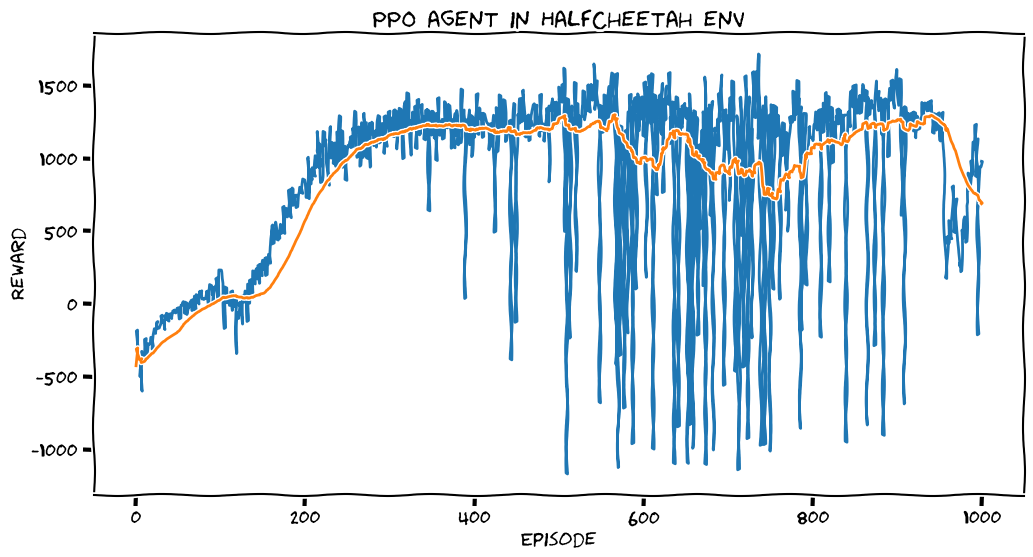

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [10]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)


actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []
train(0, 1000, 1, path)

In [11]:
from google.colab import files

!zip -r p1.zip checkpoint/
files.download("p1.zip")

  adding: checkpoint/ (stored 0%)
  adding: checkpoint/rewards_history.json (deflated 50%)
  adding: checkpoint/critic_losses.json (deflated 55%)
  adding: checkpoint/critic.pth (deflated 8%)
  adding: checkpoint/actor_losses.json (deflated 51%)
  adding: checkpoint/actor.pth (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode:1000->	 Reward:1318.07->	 actor loss:-1.903354,	 critic loss:555.921906
Episode:1100->	 Reward:1374.60->	 actor loss:-1.506984,	 critic loss:484.067215
Episode:1200->	 Reward:1452.84->	 actor loss:-1.832150,	 critic loss:502.527695
Episode:1300->	 Reward:1497.18->	 actor loss:-3.733747,	 critic loss:522.201042
Episode:1400->	 Reward:1547.86->	 actor loss:-2.464715,	 critic loss:556.852562
Episode:1500->	 Reward:1597.46->	 actor loss:-5.740008,	 critic loss:639.257477
Episode:1600->	 Reward:1612.79->	 actor loss:6.981935,	 critic loss:1776.542755
Episode:1700->	 Reward:1647.09->	 actor loss:0.081340,	 critic loss:753.942078
Episode:1800->	 Reward:1632.17->	 actor loss:-2.418889,	 critic loss:669.959442
Episode:1900->	 Reward:1593.44->	 actor loss:3.941652,	 critic loss:765.089020


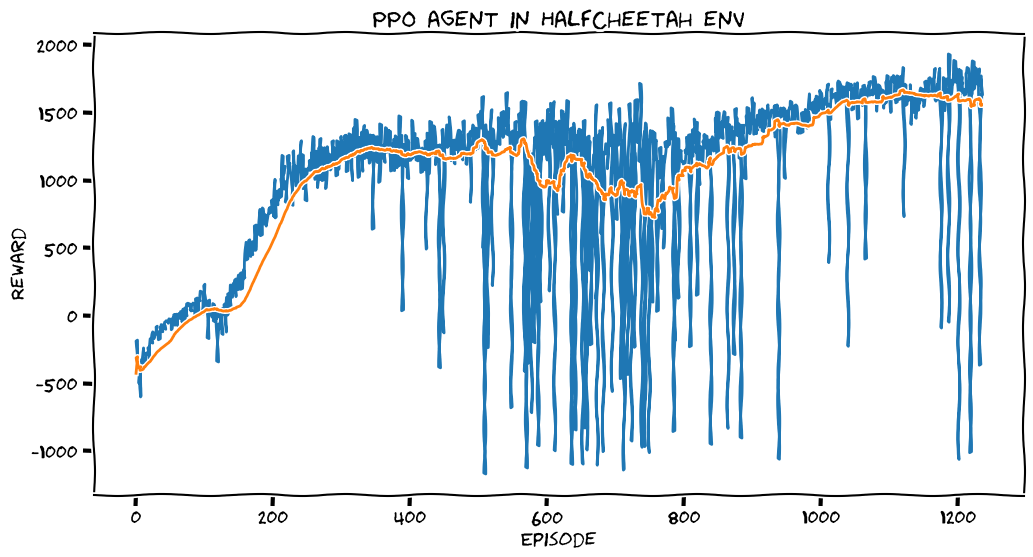

<Figure size 1200x600 with 0 Axes>

updating: checkpoint/ (stored 0%)
updating: checkpoint/rewards_history.json (deflated 50%)
updating: checkpoint/critic_losses.json (deflated 56%)
updating: checkpoint/critic.pth (deflated 8%)
updating: checkpoint/actor_losses.json (deflated 51%)
updating: checkpoint/actor.pth (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

In [12]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 3, path)

!zip -r p1.zip checkpoint/
files.download("p1.zip")

Episode:1300->	 Reward:1524.01->	 actor loss:-7.601272,	 critic loss:1175.023605
Episode:1400->	 Reward:1327.07->	 actor loss:14.528273,	 critic loss:3035.098328
Episode:1500->	 Reward:855.03->	 actor loss:-5.205879,	 critic loss:1762.926361
Episode:1600->	 Reward:999.06->	 actor loss:10.328829,	 critic loss:1722.695801
Episode:1700->	 Reward:965.21->	 actor loss:-6.408551,	 critic loss:1579.088562
Episode:1800->	 Reward:1140.99->	 actor loss:-29.415870,	 critic loss:2533.923126
Episode:1900->	 Reward:1266.34->	 actor loss:1.304279,	 critic loss:1694.483368
Episode:2000->	 Reward:1616.25->	 actor loss:-12.012628,	 critic loss:2196.794281
Episode:2100->	 Reward:1301.08->	 actor loss:-3.281975,	 critic loss:1597.701569
Episode:2200->	 Reward:1416.25->	 actor loss:2.485959,	 critic loss:1799.230713


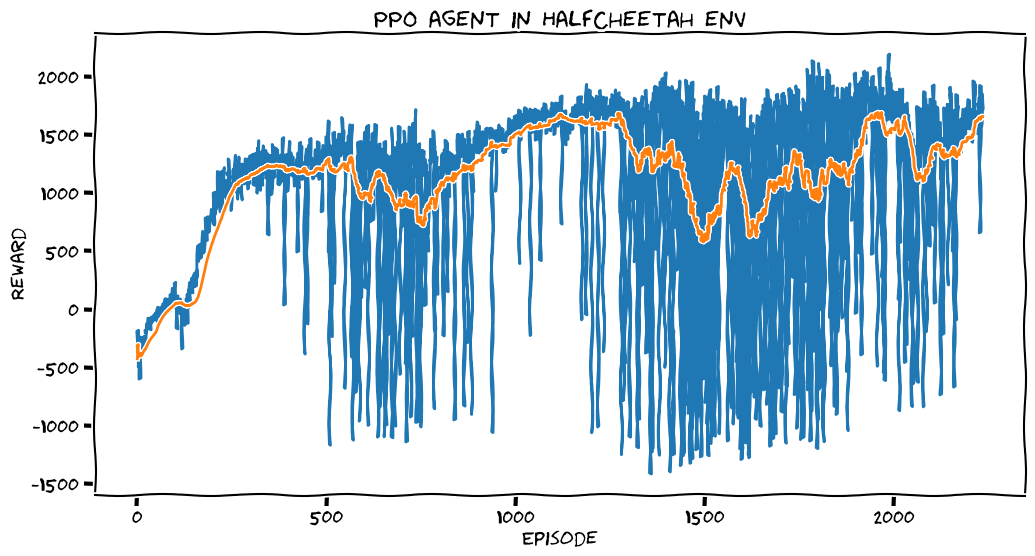

<Figure size 1200x600 with 0 Axes>

updating: checkpoint/ (stored 0%)
updating: checkpoint/rewards_history.json (deflated 51%)
updating: checkpoint/critic_losses.json (deflated 59%)
updating: checkpoint/critic.pth (deflated 8%)
updating: checkpoint/actor_losses.json (deflated 52%)
updating: checkpoint/actor.pth (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

In [13]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 1, path)

!zip -r p1.zip checkpoint/
files.download("p1.zip")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode:2300->	 Reward:1833.94->	 actor loss:4.050401,	 critic loss:2471.387299
Episode:2400->	 Reward:2429.93->	 actor loss:-14.002625,	 critic loss:3246.124878
Episode:2500->	 Reward:2497.97->	 actor loss:-10.017781,	 critic loss:2740.666809
Episode:2600->	 Reward:2539.88->	 actor loss:-20.547799,	 critic loss:3176.126831
Episode:2700->	 Reward:2588.62->	 actor loss:-3.412488,	 critic loss:4377.426575
Episode:2800->	 Reward:2754.55->	 actor loss:-20.128802,	 critic loss:3919.164368
Episode:2900->	 Reward:2742.39->	 actor loss:13.973252,	 critic loss:3264.472900
Episode:3000->	 Reward:2589.27->	 actor loss:2.568006,	 critic loss:3021.624207
Episode:3100->	 Reward:2684.04->	 actor loss:5.278435,	 critic loss:4679.485413
Episode:3200->	 Reward:2903.34->	 actor loss:-7.529620,	 critic loss:4208.358948


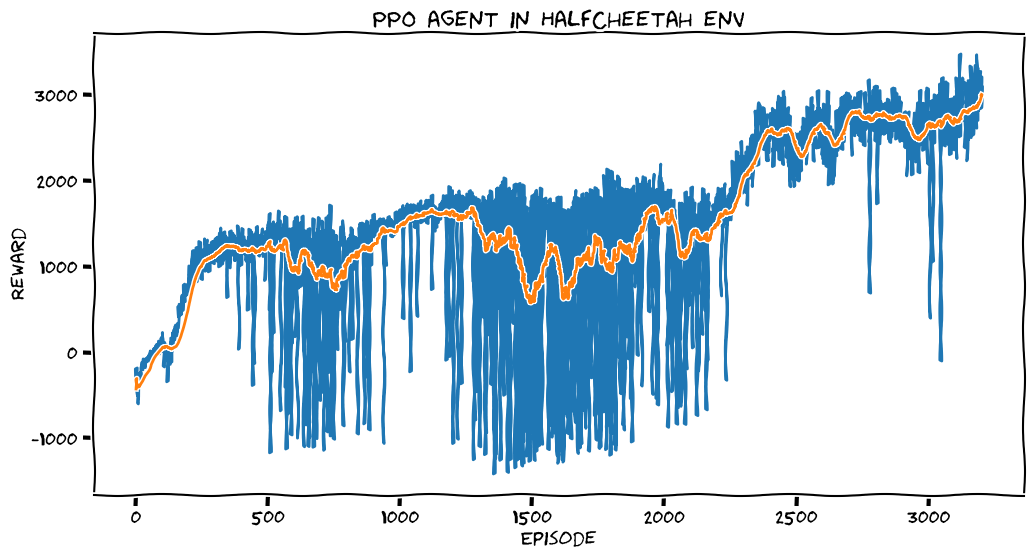

<Figure size 1200x600 with 0 Axes>

  adding: checkpoint/ (stored 0%)
  adding: checkpoint/actor.pth (deflated 9%)
  adding: checkpoint/critic_losses.json (deflated 61%)
  adding: checkpoint/actor_losses.json (deflated 52%)
  adding: checkpoint/rewards_history.json (deflated 51%)
  adding: checkpoint/critic.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

In [12]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 1, path)

!zip -r p2.zip checkpoint/
files.download("p2.zip")

Episode:3300->	 Reward:2931.15->	 actor loss:-4.283260,	 critic loss:4438.979980
Episode:3400->	 Reward:2913.80->	 actor loss:-11.356448,	 critic loss:4058.316956
Episode:3500->	 Reward:2981.04->	 actor loss:12.471563,	 critic loss:3972.115601
Episode:3600->	 Reward:2896.41->	 actor loss:17.452592,	 critic loss:4627.053223
Episode:3700->	 Reward:3001.83->	 actor loss:12.517086,	 critic loss:3190.483643
Episode:3800->	 Reward:2829.80->	 actor loss:15.675304,	 critic loss:4765.979675
Episode:3900->	 Reward:3029.34->	 actor loss:-26.353312,	 critic loss:4416.165771
Episode:4000->	 Reward:2969.65->	 actor loss:-20.766052,	 critic loss:4398.666016
Episode:4100->	 Reward:2998.59->	 actor loss:-16.665203,	 critic loss:4551.833435
Episode:4200->	 Reward:3069.82->	 actor loss:-8.357357,	 critic loss:4541.127258


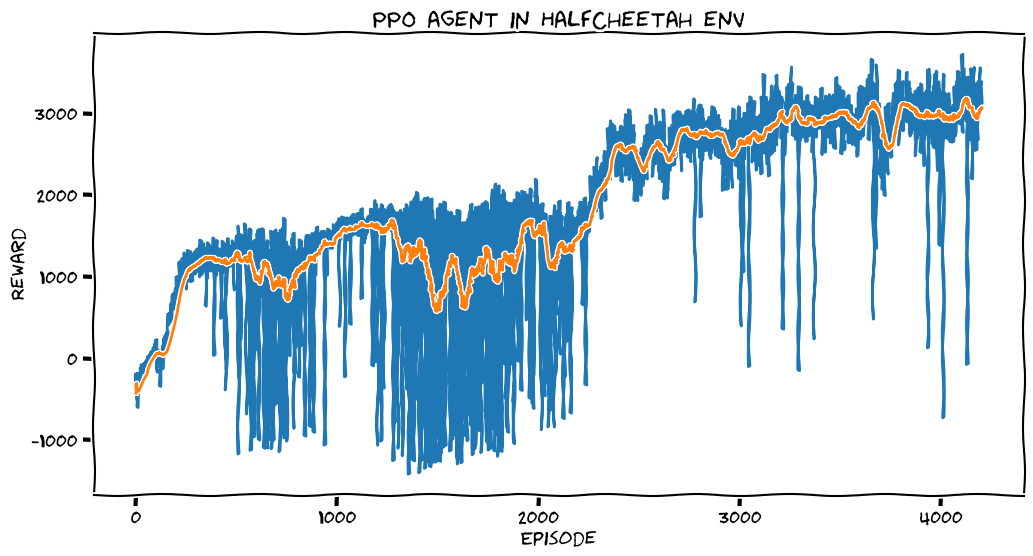

<Figure size 1200x600 with 0 Axes>

updating: checkpoint/ (stored 0%)
updating: checkpoint/actor.pth (deflated 9%)
updating: checkpoint/critic_losses.json (deflated 62%)
updating: checkpoint/actor_losses.json (deflated 52%)
updating: checkpoint/rewards_history.json (deflated 51%)
updating: checkpoint/critic.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

In [14]:
path = "checkpoint/"
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config, actor_path= path + "actor.pth", critic_path= path + "critic.pth")
agent.memory.clear()

rewards_history, actor_losses, critic_losses = load_plot_metrics(path)


train(len(rewards_history), 1000, 1, path)

!zip -r p2.zip checkpoint/
files.download("p2.zip")

# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [15]:
# Create environment
%env MUJOCO_GL=egl
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

state, info = env.reset()
done = False
total_reward = 0

# run the learned PPO agent to evaluate it
#TODO
while not done:
    # Select action and get next state and reward
    with torch.no_grad():
        action = agent.select_action(state)

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    frames.append(env.render())
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

env: MUJOCO_GL=egl
Total Reward: 3564.995422125154
